# Instruções iniciais

Neste notebook você irá elaborar curvas de campo para Sondagens Elétricas Verticais (SEVs) aprender como funciona a remoção de componentes de frequências indesejadas em sinais através do processo de filtragem. Para isto leia atentamente as instruções apresentadas antes de cada célula e execute-as uma a uma, para acompanhar o processo corretamente.

Não se preocupe em compreender o código em si, não é obrigatório que você conheça a programação para obter e interpretar os resultados da demonstração. Mesmo assim, sinta-se livre caso queira perguntar qualquer coisa para aprender mais sobre o código e sua elaboração.

 
# Passo 01 - Preparação

Primeiramente vamos preparar o notebook com os pacotes, módulos e funções que precisaremos no decorrer da demonstração. A célula abaixo executa a instalação do pacote open sourece [SimPEG](https://docs.simpeg.xyz/), responsável por executar os cálculos relacionados à física do problema. Se você está executando este notebook no MyBinder ou no Google Colab não se preocupe, nada será instalado na sua máquina local. Execute esta célula uma vez antes de executar qualquer outra parte do código e não altere nada no código apresentado na célula para não criar problemas na execução do código.

Você pode executar o código na célula clicando sobre ela e em seguida clicando no botão RUN na barra do Jupyter Notebook ou pressionando as teclas SHIFT+ENTER no seu teclado. A execução desta primeira célula pode demorar um pouco, pois um pacote inteiro estará sendo instalado. Aguarde o término da instalção antes de executar a célula seguinte.

<p>&nbsp;</p>

**Importante!** Nem todas as células de código desta demostração irão retornar algum tipo de mensagem ou figura após a execução. Isto é normal e não significa que a execução tenha falhado. Perceba o símbolo In [ ]: próximo ao canto superior esquerdo de cada célula. Ao iniciar a execução de uma delas você verá um asterisco ($*$) aparecer dentro dos colchetes. Você saberá que a execução ocorreu sem problemas quando o $*$ dentro dos colchetes for substituído por um número e nenhuma mensagem de erro aparecer abaixo da célula executada.

In [69]:
# importa e instala o SimPEG
# baseado no exemplo em https://docs.simpeg.xyz/content/tutorials/05-dcr/plot_fwd_1_dcr_sounding.html#sphx-glr-content-tutorials-05-dcr-plot-fwd-1-dcr-sounding-py

!git clone https://github.com/simpeg/simpeg
%cd simpeg
!pip install -r requirements.txt
!python setup.py install

remote: Enumerating objects: 717, done.
remote: Counting objects: 100% (717/717), done.
remote: Compressing objects: 100% (427/427), done.
remote: Total 52929 (delta 484), reused 442 (delta 279), pack-reused 52212
Receiving objects: 100% (52929/52929), 78.99 MiB | 23.09 MiB/s, done.
Resolving deltas: 100% (38770/38770), done.
/content/simpeg/simpeg/simpeg
Obtaining file:///content/simpeg/simpeg/simpeg (from -r requirements.txt (line 1))
  Found existing installation: SimPEG 0.14.3
    Uninstalling SimPEG-0.14.3:
      Successfully uninstalled SimPEG-0.14.3
  Running setup.py develop for SimPEG
running install
running bdist_egg
running egg_info
writing SimPEG.egg-info/PKG-INFO
writing dependency_links to SimPEG.egg-info/dependency_links.txt
writing requirements to SimPEG.egg-info/requires.txt
writing top-level names to SimPEG.egg-info/top_level.txt
reading manifest template 'MANIFEST.in'
writing manifest file 'SimPEG.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86

In [70]:
import os
import numpy as np
import matplotlib.pyplot as plt

from discretize import TensorMesh

from SimPEG import maps
from SimPEG.electromagnetics.static import resistivity as dc
from SimPEG.electromagnetics.static.utils.static_utils import plot_layer

save_file = False

In [82]:
class schlumberger():

    """
    Sondagem Elétrica Vertical em arranjo Schlumberger configuada para uso com
    o SimPEG
    """

    def __init__(self, meioAB, meioMN):

        if len(meioAB)>len(meioMN):
            print("\nERRO: número de posições de AB/2 é maior do número de "
                "posições de MN/2.\n")
            return None
          
        elif len(meioAB)<len(meioMN):
            print("\nERRO: número de posições de AB/2 é menor do número de "
                "posições de MN/2.\n")
            return None

        else:
            self.arranjo = 'Schlumberger'
            self.meioAB = meioAB      # distâncias de AB/2
            self.meioMN = meioMN      # distâncias de MN/2
            source_list = []

            for ii in range(len(meioAB)):
                A = np.r_[-1 * meioAB[ii], 0.0,0.0]
                B = np.r_[meioAB[ii], 0.0,0.0]
                M = np.r_[-1 * meioMN[ii], 0.0,0.0]
                N = np.r_[meioMN[ii], 0.0,0.0]

                receiver_list = [dc.receivers.Dipole(M, N)]
                source_list.append(dc.sources.Dipole(receiver_list, A, B))

            self.survey = dc.Survey(source_list)

            # inicializa sem nada porque ainda não foi feita a modelagem
            self.rho_a = None


    def fwd(self, modelo):

        simulation = dc.simulation_1d.Simulation1DLayers(
                      survey = self.survey,
                      rhoMap = modelo.model_map,
                      thicknesses = modelo.h,
                      data_type = "apparent_resistivity"
                      )

        self.rho_a = simulation.dpred(modelo.rho)



class modelo_geo():

    def __init__(self, rho, h):

        self.rho = rho
        self.h = h
        self.z_max = np.sum(self.h) * 1.3

        # Define mapping from model to 1D layers
        self.model_map = maps.IdentityMap(nP=len(self.rho))


    def mostra_grafico(self):

        # Define a 1D mesh for plotting.
        mesh = TensorMesh([np.r_[self.h, self.z_max - self.h.sum()]])

        fig, ax1 = plt.subplots(figsize=(4,4))
        plot_layer(self.model_map * self.rho, mesh, xlim=[10, 1e4], \
                   ax=ax1, showlayers=True)

        ax1.set_xlabel('Resistividade (Ohm.m)')
        ax1.set_ylabel('Profundidade(m)')
        ax1.set_title('Modelo de ' + str(len(self.rho)) + ' camadas')
        ax1.grid(which='both')
        plt.show()


def plota_sondagem(sondagem, modelo):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 7))

    ax[0].loglog(sondagem.meioAB, sondagem.rho_a, '-b')
    ax[0].plot(sondagem.meioAB, sondagem.rho_a, 'ok')
    ax[0].set_xlabel('AB/2 (m)', fontsize='14')
    ax[0].set_ylabel('Resistividade Aparente ($\Omega$.m)', fontsize='14')
    ax[0].set_ylim([10, 1000])
    ax[0].set_xlim([1, 1000])
    ax[0].grid(which='both')
    
    mesh = TensorMesh([np.r_[modelo.h, modelo.z_max - modelo.h.sum()]])
    plot_layer(modelo.model_map * modelo.rho, mesh, xlim=[10, 1e4], \
                ax=ax[1], showlayers=True)
    ax[1].set_xlabel('Resistividade (Ohm.m)')
    ax[1].set_ylabel('Profundidade(m)')
    ax[1].set_title('Modelo de ' + str(len(modelo.rho)) + ' camadas')
    ax[1].grid(which='both')

    plt.show()









# Passo 02 - Configuração do modelo geoelétrico

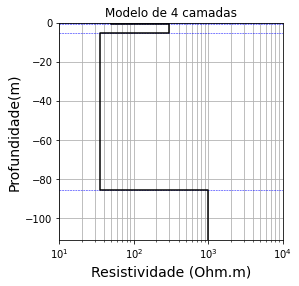

In [78]:
# modelo 1D - S40 Bebedouro
resistividades = np.r_[50.0, 300.0, 35.0, 1000]
espessuras = np.r_[0.5, 5.0, 80.0]

modelo_beb40 = modelo_geo(resistividades, espessuras)
modelo_beb40.mostra_grafico()

# Passo 03 - Configuração da SEV

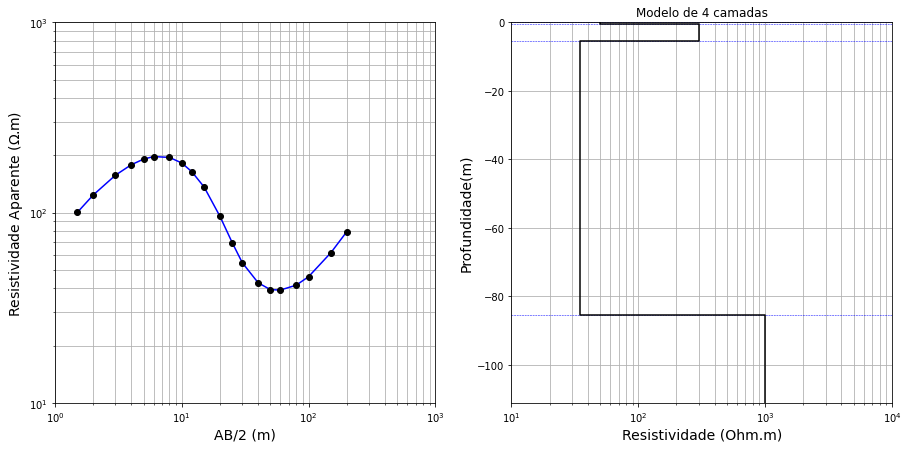

In [83]:
eletrodos_AB = np.array([1.5, 2.0, 3.0, 4.0, 5.0, 6.0, 8.0, 10.0, 12.0, \
                         15.0, 20.0, 25.0, 30.0, 40.0, 50.0, 60.0, 80.0, \
                         100.0, 150.0, 200.0])
eletrodos_MN = np.array([0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 1.0, 1.0, 1.0, \
                         2.0, 2.0, 2.0, 2.0, 5.0, 5.0, 10.0, 10.0, \
                         10.0, 10.0, 10.0])

sev = schlumberger(eletrodos_AB, eletrodos_MN)

sev.fwd(modelo_beb40)

plota_sondagem(sev, modelo_beb40)

In [ ]:
# arranjo wenner
aberturas = np.array([1.5, 2.0, 3.0, 4.0, 5.0, 6.0, 8.0, 10.0, 12.0, 15.0, 20.0, 25.0, 30.0, 40.0, 50.0, 60.0, 80.0, 100.0, 150.0, 200.0])      # posições dos eletrodos A

wenner = np.array([[a, a/3] for a in aberturas])

source_list_wenner = []

for ii in range(wenner.shape[0]):
  A = np.r_[-1 * wenner[ii, 0], 0.0,0.0]
  B = np.r_[wenner[ii, 0], 0.0,0.0]
  M = np.r_[-1 * wenner[ii, 1], 0.0,0.0]
  N = np.r_[ wenner[ii, 1], 0.0,0.0]

  receiver_list = [dc.receivers.Dipole(M, N)]
  source_list_wenner.append(dc.sources.Dipole(receiver_list, A, B))

survey_wenner = dc.Survey(source_list_wenner)

In [ ]:
# Modelagens
simulation_wenner = dc.simulation_1d.Simulation1DLayers(
    survey = survey_wenner,
    rhoMap = model_map,
    thicknesses=layer_thicknesses,
    data_type="apparent_resistivity"
)

dpred_wenner = simulation_wenner.dpred(model)

In [ ]:
fig, ax1 = plt.subplots(figsize=(5, 7))
ax1.loglog(schlumberger[:,0], dpred_schlumberger, 'b', label='Schlumberger')
ax1.plot(schlumberger[:,0], dpred_schlumberger, 'ob')
ax1.loglog(wenner[:,0], dpred_wenner, '--r', label='Wenner')
ax1.plot(wenner[:,0], dpred_wenner, '.r')
ax1.set_xlabel('AB/2 (m)', fontsize='14')
ax1.set_ylabel('Resistividade Aparente ($\Omega$.m)', fontsize='14')
ax1.set_ylim([10, 1000])
ax1.legend(loc='upper right')
ax1.grid(which='both')
plt.show()